## Nikshay Jain | MM21B044
### DA5400: Assign 2

In [183]:
import re, os
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns

In [112]:
data = pd.read_csv('enron_spam_data.csv')

In [113]:
data

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14
...,...,...,...,...,...
33711,33711,= ? iso - 8859 - 1 ? q ? good _ news _ c = eda...,"hello , welcome to gigapharm onlinne shop .\np...",spam,2005-07-29
33712,33712,all prescript medicines are on special . to be...,i got it earlier than expected and it was wrap...,spam,2005-07-29
33713,33713,the next generation online pharmacy .,are you ready to rock on ? let the man in you ...,spam,2005-07-30
33714,33714,bloow in 5 - 10 times the time,learn how to last 5 - 10 times longer in\nbed ...,spam,2005-07-30


### EDA + preprocessing

In [114]:
data = data.drop(['Message ID', 'Date'], axis=1)
data['Spam/Ham'].replace({'spam': 1, 'ham': 0}, inplace=True)
data = data.rename(columns={'Spam/Ham': 'label'})
data.fillna("", inplace = True)

In [118]:
data

,Subject,Message,label
0,christmas tree farm pictures,,0
1,"vastar resources , inc .","gary , production from the high island larger ...",0
2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,0
3,re : issue,fyi - see note below - already done .\nstella\...,0
4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,0
...,...,...,...
33711,= ? iso - 8859 - 1 ? q ? good _ news _ c = eda...,"hello , welcome to gigapharm onlinne shop .\np...",1
33712,all prescript medicines are on special . to be...,i got it earlier than expected and it was wrap...,1
33713,the next generation online pharmacy .,are you ready to rock on ? let the man in you ...,1
33714,bloow in 5 - 10 times the time,learn how to last 5 - 10 times longer in\nbed ...,1


In [85]:
data['Spam/Ham'] = 1 if "spam" else 0

In [45]:
sum(data['Spam/Ham']=='spam')/sum(data['Spam/Ham']=='ham')   # ratio of spam:ham

1.0378362042913267

In [119]:
def make_usable(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)    # Remove special characters and digits
    return text.split()

data['body'] = (data['Message']).apply(make_usable)

In [152]:
data

,Subject,Message,label,body
0,christmas tree farm pictures,,0,[]
1,"vastar resources , inc .","gary , production from the high island larger ...",0,"[gary, production, from, the, high, island, la..."
2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,0,"[calpine, daily, gas, nomination, doc]"
3,re : issue,fyi - see note below - already done .\nstella\...,0,"[fyi, see, note, below, already, done, stella,..."
4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,0,"[fyi, forwarded, by, lauri, a, allen, hou, ect..."
...,...,...,...,...
33711,= ? iso - 8859 - 1 ? q ? good _ news _ c = eda...,"hello , welcome to gigapharm onlinne shop .\np...",1,"[hello, welcome, to, gigapharm, onlinne, shop,..."
33712,all prescript medicines are on special . to be...,i got it earlier than expected and it was wrap...,1,"[i, got, it, earlier, than, expected, and, it,..."
33713,the next generation online pharmacy .,are you ready to rock on ? let the man in you ...,1,"[are, you, ready, to, rock, on, let, the, man,..."
33714,bloow in 5 - 10 times the time,learn how to last 5 - 10 times longer in\nbed ...,1,"[learn, how, to, last, times, longer, in, bed,..."


In [121]:
X_train, X_test, y_train, y_test = train_test_split(data['body'], data['label'], test_size=0.2)

### Naive Bayes Algo

In [122]:
# Get word frequencies for each class
sp_word = []
hm_word = []

for words, label in zip(X_train, y_train):
    if label == 1:
        sp_word.extend(words)
    else:
        hm_word.extend(words)

sp_word_counts = Counter(sp_word)
hm_word_counts = Counter(hm_word)

In [125]:
# Calculate probabilities
total_spam_words = sum(spam_word_counts.values())
total_ham_words = sum(ham_word_counts.values())
vocab = list(set(spam_word_counts.keys()).union(set(ham_word_counts.keys())))
vocab_size = len(vocab)

# Calculate prior probabilities for each class
p_spam = y_train.mean()
p_ham = 1 - p_spam

# Laplace smoothing
alpha = 1
spam_word_probs = {word: (spam_word_counts[word] + alpha) / (total_spam_words + alpha * vocab_size) for word in vocab}
ham_word_probs = {word: (ham_word_counts[word] + alpha) / (total_ham_words + alpha * vocab_size) for word in vocab}

In [144]:
def predict(words):
    spam_score = np.log(p_spam)
    ham_score = np.log(p_ham)

    vocab_set = set(vocab)

    # Precompute log probabilities for known words
    for word in words:
        if word in vocab_set:  # Check membership in the set
            spam_word_prob = spam_word_probs.get(word, alpha / (total_spam_words + alpha * vocab_size))
            ham_word_prob = ham_word_probs.get(word, alpha / (total_ham_words + alpha * vocab_size))
            spam_score += np.log(spam_word_prob)
            ham_score += np.log(ham_word_prob)

    return 1 if spam_score > ham_score else 0

In [151]:
# Predict on test set
y_pred = X_test.apply(predict)

Accuracy: 98.36892052194544%


In [177]:
# Evaluate over metrics
accuracy = (y_pred == y_test).mean()
f1 = f1_score(y_pred,y_test)
print(f'f1-score: {f1:.4f}')
print(f'Accuracy: {accuracy * 100:.2f}%')

f1-score: 0.9840
Accuracy: 98.37%


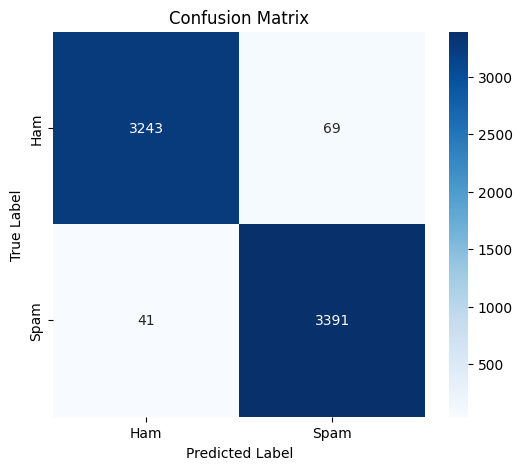

In [178]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Save the trained model to a file
with open('spam_ham_model.pkl', 'wb') as model_file:
    pickle.dump((spam_word_probs, ham_word_probs, p_spam, p_ham, total_spam_words, total_ham_words, vocab), model_file)

In [171]:
def test_spam(folder_path='test'):
    results = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            filepath = os.path.join(folder_path, filename)
            with open(filepath, 'r') as file:
                email_content = file.read()
                words = make_usable(email_content)
                prediction = predict(words)
                results.append((filename, prediction))

    # Write results to CSV
    with open(output_csv, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Filename', 'Prediction'])   # Header
        writer.writerows(results)

    print(f"Predictions saved to {output_csv}")

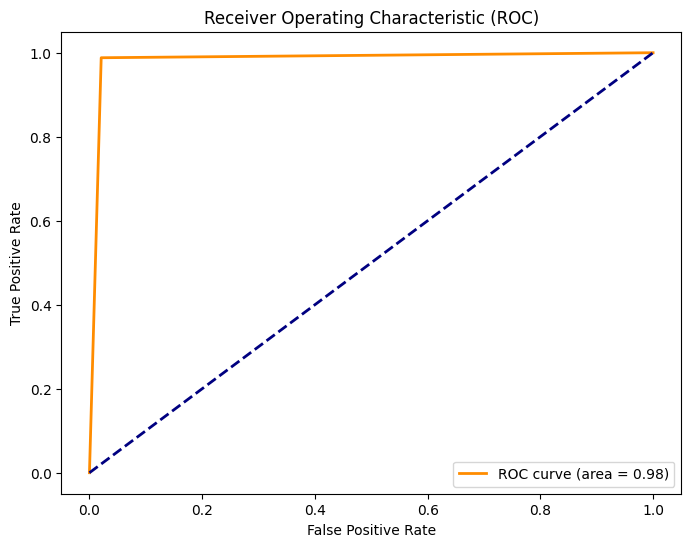

In [184]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()